In [23]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import json

## Global Variables

In [24]:
start_year = 2013
end_year = 2024

climate_dir = "climate_timeseries"
vegetation_dir = "cluster_timeseries/classification_result"
evi = True

# kecamatan_names = ['warungkondang', 'cibeber', 'campaka']
kecamatan_names = ['warungkondang']
# available_climate_datasets = ['POWER_warungkondang.csv', 'POWER_cibeber.csv']
# available_climate_datasets = ['era5_warungkondang.csv', 'era5_cibeber.csv', 'era5_campaka.csv']
# available_vegetation_datasets = ['warungkondang.csv', 'cibeber3.csv', 'campaka']
available_climate_datasets = ['era5_warungkondang.csv']
available_vegetation_datasets = ['warungkondang.csv']

if evi:
    for i in range(len(available_vegetation_datasets)):
        available_vegetation_datasets[i] = 'evi_' + str(available_vegetation_datasets[i])

era5_features = [
        # Temperature variables
        'temperature_2m',                       # Air temperature
        'temperature_2m_min',                   # Daily minimum air temperature
        'temperature_2m_max',                   # Daily maximum air temperature
        'soil_temperature_level_1',             # Topsoil temperature (0-7 cm)
        'soil_temperature_level_2',             # Soil temperature (7-28 cm)
        
        # Moisture variables
        'volumetric_soil_water_layer_1',        # Topsoil moisture content
        'volumetric_soil_water_layer_2',        # Soil moisture (7-28 cm)
        'volumetric_soil_water_layer_3',        # Soil moisture (28-100 cm)
        'total_precipitation_sum',              # Total rainfall and snow
        'dewpoint_temperature_2m',              # Air humidity indicator
        
        # Radiation and energy variables
        'surface_solar_radiation_downwards_sum', # Solar radiation at surface
        'surface_net_solar_radiation_sum',       # Net solar radiation at surface
        
        # Evaporation and water cycle
        'total_evaporation_sum',                 # Actual evaporation
        
        # Wind variables
        'u_component_of_wind_10m',               # East-west wind component
        'v_component_of_wind_10m'                # North-south wind component
    ]

extract_statistics = ['mean', 'min', 'max', 'std']
statistic_corr = ['mean', 'min', 'max', 'std', 'smoothed_mean']

## Global Functions

In [25]:
def difference_df(df):
    df = df.diff()
    return df

## Climate Datasets

In [26]:
# df_OpenWeather = pd.read_csv(f"{data_dir}/OpenWeather_pandanwangi.csv")
climate_df = {}
try:
    for i, dataset in enumerate(available_climate_datasets):
        curr = pd.read_csv(f"{climate_dir}/{dataset}")
        climate_df[kecamatan_names[i]] = curr
except:
    print(f"file kecamatan {kecamatan_names[i]} belum ada")

In [27]:
preprocessed_climate = {}
def power_climate_preprocessing(df):
    df['datetime'] = pd.to_datetime(df['YEAR'].astype(str) + 
                                  df['DOY'].astype(str), 
                                  format='%Y%j')

    df.set_index('datetime', inplace=True) # set kolom DATE sebagai index terbaru
    df = df.drop(columns=['YEAR', 'DOY'], axis=0)
    df = df.replace(-999, np.nan)
    df = df.ffill()

    '''
    Columns description:
    T2M           MERRA-2 Temperature at 2 Meters (C)
    T2MDEW        MERRA-2 Dew/Frost Point at 2 Meters (C)
    T2MWET        MERRA-2 Wet Bulb Temperature at 2 Meters (C)
    TS            MERRA-2 Earth Skin Temperature (C)
    T2M_RANGE     MERRA-2 Temperature at 2 Meters Range (C)
    T2M_MAX       MERRA-2 Temperature at 2 Meters Maximum (C)
    T2M_MIN       MERRA-2 Temperature at 2 Meters Minimum (C)
    PS            MERRA-2 Surface Pressure (kPa)
    WS2M          MERRA-2 Wind Speed at 2 Meters (m/s)
    WS2M_MAX      MERRA-2 Wind Speed at 2 Meters Maximum (m/s)
    WS2M_MIN      MERRA-2 Wind Speed at 2 Meters Minimum (m/s)
    GWETTOP       MERRA-2 Surface Soil Wetness (1)
    GWETROOT      MERRA-2 Root Zone Soil Wetness (1)
    '''
    return df[(df.index.year >= start_year) & (df.index.year <= end_year)]

def era5_climate_preprocessing(df):
    df['datetime'] = pd.to_datetime(df['date'], format='%Y%m%d')
    df.set_index('datetime', inplace=True) # set kolom DATE sebagai index terbaru

    df = df[era5_features]
    return df[(df.index.year >= start_year) & (df.index.year <= end_year)]

for kec in kecamatan_names:
    preprocessed_climate[kec] = era5_climate_preprocessing(climate_df[kec])

In [28]:
print(preprocessed_climate["warungkondang"].head())

            temperature_2m  temperature_2m_min  temperature_2m_max  \
datetime                                                             
2013-01-01      294.247430          292.679531          296.335467   
2013-01-02      295.012854          292.714263          298.470551   
2013-01-03      295.520867          293.294702          300.030032   
2013-01-04      294.552825          292.350513          297.182733   
2013-01-05      294.156373          292.562726          297.044142   

            soil_temperature_level_1  soil_temperature_level_2  \
datetime                                                         
2013-01-01                295.740102                296.259192   
2013-01-02                296.462650                296.402809   
2013-01-03                296.847501                296.743497   
2013-01-04                296.226519                296.517556   
2013-01-05                295.621383                296.048674   

            volumetric_soil_water_layer_1  vol

## Vegetation Datasets

In [29]:
vegetation_df = {}

try:
    for i, dataset in enumerate(available_vegetation_datasets):
        curr = pd.read_csv(f"{vegetation_dir}/{dataset}")
        vegetation_df[kecamatan_names[i]] = curr
except:
    ""

In [30]:
print(vegetation_df['warungkondang']['label'].describe())

count                1277
unique                  2
top       non-pandanwangi
freq                  699
Name: label, dtype: object


In [31]:
preprocessed_vegetation = {}

def vegetation_preprocessing(df):
    df = df.iloc[:, 1:]
    df = df[df.label == 'pandanwangi']
    df = df.set_index('cluster_id')
    df = df.describe()
    df = df.T
    df = df[extract_statistics]
    indexes = df.index
    new_indexes = []
    for i in indexes:
        date = pd.to_datetime(i, format='%Y%m%d')
        new_indexes.append(date)
    df['datetime'] = new_indexes
    df = df.set_index('datetime')
    df = df.asfreq('5D', method='nearest')

    return df[(df.index.year >= start_year) & (df.index.year <= end_year)]

for kec in kecamatan_names:
    preprocessed_vegetation[kec] = vegetation_preprocessing(vegetation_df[kec])

In [32]:
print(preprocessed_vegetation["warungkondang"])

                mean       min       max       std
datetime                                          
2013-05-21  0.440012  0.112779  0.675163  0.115873
2013-05-26  0.439836  0.112779  0.675163  0.115758
2013-05-31  0.439836  0.112779  0.675163  0.115758
2013-06-05  0.439836  0.112779  0.675163  0.115758
2013-06-10  0.436973  0.112779  0.675163  0.117097
...              ...       ...       ...       ...
2024-10-20  0.545838  0.212346  0.730457  0.083558
2024-10-25  0.544258  0.150435  3.012866  0.142205
2024-10-30  0.506222  0.149170  0.702844  0.100415
2024-11-04  0.550267  0.157799  2.919508  0.134652
2024-11-09  0.521237  0.157248  2.962225  0.143140

[839 rows x 4 columns]


In [33]:
smoothed_vegetation = {}

def smoothing_sg(df):
    filtered = savgol_filter(df['mean'], window_length=30, polyorder=4)
    df['smoothed_mean'] = filtered
    return df
    
for kec in kecamatan_names:
    smoothed_vegetation[kec] = smoothing_sg(preprocessed_vegetation[kec])

In [34]:
print(smoothed_vegetation['warungkondang'])

                mean       min       max       std  smoothed_mean
datetime                                                         
2013-05-21  0.440012  0.112779  0.675163  0.115873       0.445595
2013-05-26  0.439836  0.112779  0.675163  0.115758       0.441179
2013-05-31  0.439836  0.112779  0.675163  0.115758       0.437803
2013-06-05  0.439836  0.112779  0.675163  0.115758       0.435395
2013-06-10  0.436973  0.112779  0.675163  0.117097       0.433883
...              ...       ...       ...       ...            ...
2024-10-20  0.545838  0.212346  0.730457  0.083558       0.537888
2024-10-25  0.544258  0.150435  3.012866  0.142205       0.537581
2024-10-30  0.506222  0.149170  0.702844  0.100415       0.535144
2024-11-04  0.550267  0.157799  2.919508  0.134652       0.530212
2024-11-09  0.521237  0.157248  2.962225  0.143140       0.522393

[839 rows x 5 columns]


In [35]:
differenced_climate = {}
differenced_vegetation = {}

intersecting_indices = preprocessed_climate['warungkondang'].index.intersection(preprocessed_vegetation['warungkondang'].index)

for kec in kecamatan_names:
    differenced_climate[kec] = difference_df(preprocessed_climate[kec].loc[intersecting_indices]).iloc[1:, :]
    differenced_vegetation[kec] = difference_df(smoothed_vegetation[kec]).loc[intersecting_indices].iloc[1:, :]

In [36]:
# differenced_climate['warungkondang'].head()

In [37]:
differenced_vegetation['warungkondang'].head()

,mean,min,max,std,smoothed_mean
datetime,,,,,
2013-05-26,-0.000176,0.0,0.0,-0.000116,-0.004417
2013-05-31,0.000000,0.0,0.0,0.000000,-0.003376
2013-06-05,0.000000,0.0,0.0,0.000000,-0.002408
2013-06-10,-0.002863,0.0,0.0,0.001339,-0.001512
2013-06-15,0.000000,0.0,0.0,0.000000,-0.000690


In [38]:
# json extract
correlation_indexes = {}

for kec in kecamatan_names:
    kec_vegetation = differenced_vegetation[kec]
    kec_climate = differenced_climate[kec]
    stat_dict = {}
    for statistic in extract_statistics:
        curr_stat = kec_vegetation[statistic]
        cuaca_dict = {}
        for faktor_cuaca in era5_features:
            pearson = curr_stat.corr(kec_climate[faktor_cuaca], method='pearson')
            spearman = curr_stat.corr(kec_climate[faktor_cuaca], method='spearman')
            corr_dict = {
                'pearson': float(pearson),
                'spearman': float(pearson)
            }
            cuaca_dict[faktor_cuaca] = corr_dict
        stat_dict[statistic] = cuaca_dict
    correlation_indexes[kec] = stat_dict
            
# print(differenced_vegetation['warungkondang']['mean'].corr(differenced_climate['warungkondang']['temperature_2m'], method='pearson'))
# print(differenced_vegetation['warungkondang']['mean'].corr(differenced_climate['warungkondang']['soil_temperature_level_1'], method='pearson'))

In [39]:
# dataframe extract
correlation_indexes = {
    'kec': [],
    'statistic': [],
    'cuaca': [],
    'pearson': [],
    'spearman': []
}

for kec in kecamatan_names:
    kec_vegetation = differenced_vegetation[kec]
    kec_climate = differenced_climate[kec]
    stat_dict = {}
    for statistic in statistic_corr:
        curr_stat = kec_vegetation[statistic]
        cuaca_dict = {}
        for faktor_cuaca in era5_features:
            pearson = curr_stat.corr(kec_climate[faktor_cuaca], method='pearson')
            spearman = curr_stat.corr(kec_climate[faktor_cuaca], method='spearman')
            correlation_indexes['pearson'].append(pearson)
            correlation_indexes['spearman'].append(spearman)
            correlation_indexes['cuaca'].append(faktor_cuaca)
            correlation_indexes['statistic'].append(statistic)
            correlation_indexes['kec'].append(kec)

In [40]:
# print(json.dumps(correlation_indexes, indent=2))
correlation_df = pd.DataFrame(correlation_indexes)

In [41]:
selected_kec = 'warungkondang'
kec_corr = correlation_df[correlation_df['kec'] == selected_kec]
kec_corr.sort_values("pearson", ascending=False).head(15)

,kec,statistic,cuaca,pearson,spearman
67,warungkondang,smoothed_mean,volumetric_soil_water_layer_3,0.089594,0.029378
66,warungkondang,smoothed_mean,volumetric_soil_water_layer_2,0.049371,0.041531
49,warungkondang,std,soil_temperature_level_2,0.028830,-0.072473
4,warungkondang,mean,soil_temperature_level_2,0.028830,-0.053797
34,warungkondang,max,soil_temperature_level_2,0.028830,-0.038392
65,warungkondang,smoothed_mean,volumetric_soil_water_layer_1,0.028238,0.034997
3,warungkondang,mean,soil_temperature_level_1,0.024668,-0.080558
33,warungkondang,max,soil_temperature_level_1,0.024668,-0.064090
48,warungkondang,std,soil_temperature_level_1,0.024668,-0.022580
40,warungkondang,max,surface_solar_radiation_downwards_sum,0.023125,-0.186827


In [42]:
kec_corr.sort_values("pearson", ascending=True).head(15)

,kec,statistic,cuaca,pearson,spearman
64,warungkondang,smoothed_mean,soil_temperature_level_2,-0.045156,0.011871
29,warungkondang,min,v_component_of_wind_10m,-0.041698,0.026959
63,warungkondang,smoothed_mean,soil_temperature_level_1,-0.037781,-0.006144
16,warungkondang,min,temperature_2m_min,-0.036578,-0.004644
28,warungkondang,min,u_component_of_wind_10m,-0.032453,0.043054
60,warungkondang,smoothed_mean,temperature_2m,-0.030460,-0.020808
62,warungkondang,smoothed_mean,temperature_2m_max,-0.028712,-0.023329
1,warungkondang,mean,temperature_2m_min,-0.021583,0.120636
31,warungkondang,max,temperature_2m_min,-0.021583,0.136093
46,warungkondang,std,temperature_2m_min,-0.021583,0.015355


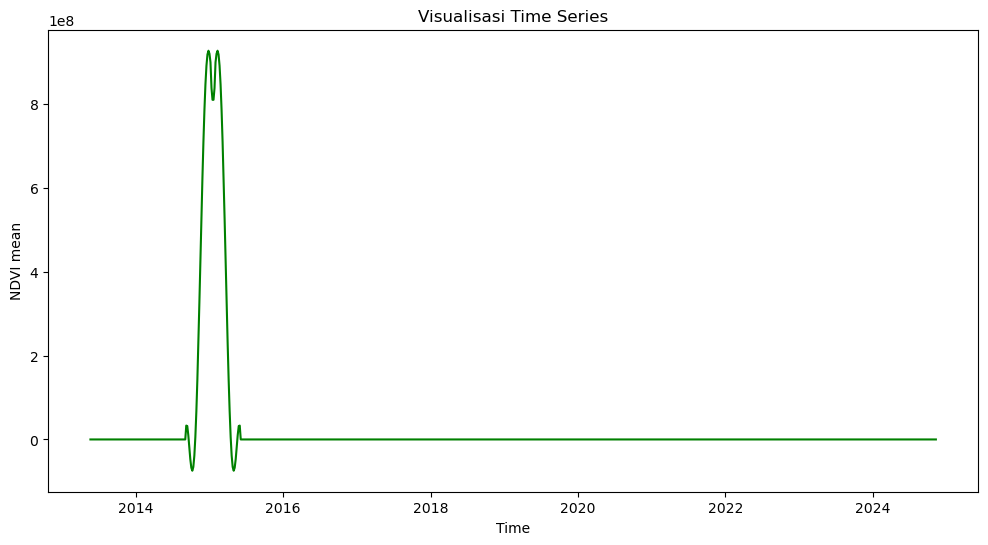

In [43]:
ts_df = preprocessed_vegetation['warungkondang']

# for stat in statistic:
plt.figure(figsize=(12, 6))
plt.plot(ts_df.index, ts_df['smoothed_mean'], label='NDVI mean', color='green')
plt.title(f'Visualisasi Time Series')
plt.xlabel('Time')
plt.ylabel('NDVI mean')
plt.show()

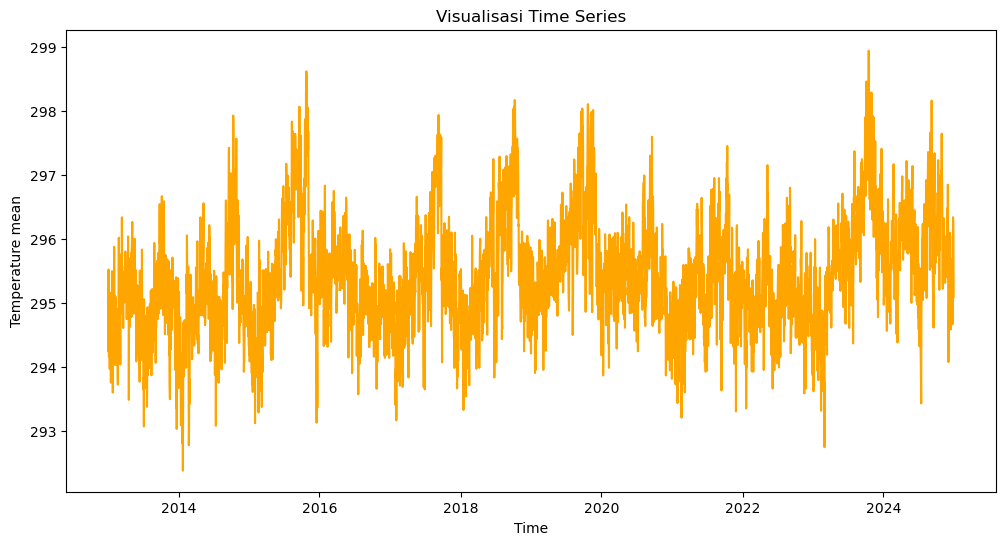

In [22]:
climate_ts = preprocessed_climate['warungkondang']

plt.figure(figsize=(12, 6))
plt.plot(climate_ts.index, climate_ts['temperature_2m'], label='temperature_2m', color='orange')
plt.title(f'Visualisasi Time Series')
plt.xlabel('Time')
plt.ylabel('Temperature mean')
plt.show()

In [41]:
diff_df

datetime
2020-01-15    0.000000
2020-01-17    0.000000
2020-01-20    0.000000
2020-01-25    0.000000
2020-03-05    0.036384
                ...   
2024-11-11   -0.048570
2024-11-14   -0.000155
2024-11-19    0.004608
2024-11-24    0.000000
2024-11-27    0.000000
Name: mean, Length: 423, dtype: float64